# Cellular automata

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [3]:
from utils import savefig

## Zero-dimensional CA

Here's a simple implementation of the 0-D CA I mentioned in the book, with one cell.

In [4]:
n = 10
x = np.zeros(n)
print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


To get the state of the cell in the next time step, we increment the current state mod 2.

In [5]:
x[1] = (x[0] + 1) % 2
x[1]

1.0

Filling in the rest of the array.

In [6]:
for i in range(2, n):
    x[i] = (x[i-1] + 1) % 2
    
print(x)

[0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


So the behavior of this CA is simple: it blinks.

## One-dimensional CA

Just as we used a 1-D array to show the state of a single cell over time, we'll use a 2-D array to show the state of a 1-D CA over time, with one column per cell and one row per timestep.

In [7]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


To plot the array use `plt.imshow`

In [8]:
# GWT: may want to discuss color maps at this point
def plot_ca(array):
    plt.imshow(array, cmap='Blues', interpolation='none')

Here's what it looks like after we initialize the first row.

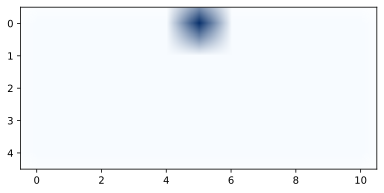

In [9]:
plot_ca(array)

And here's the function that fills in the next row.  The rule for this CA is to take the sum of a cell and its two neighbors mod 2.

In [10]:
def step(array, i):
    rows, cols = array.shape
    for j in range(1, cols):
        array[i, j] = sum(array[i-1, j-1:j+2]) % 2

Here's the second row.

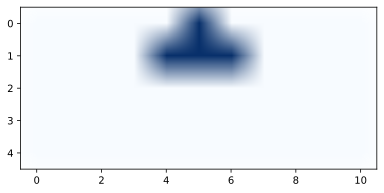

In [11]:
step(array, 1)
plot_ca(array)

And here's what it looks like with the rest of the cells filled in.

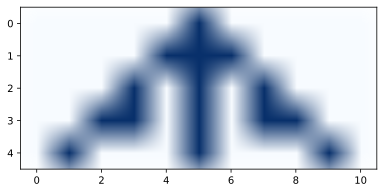

In [12]:
for i in range(1, rows):
    step(array, i)

plot_ca(array)

For a simple set of rules, the behavior is more interesting than you might expect.

**Exercise:** Modify this code to increase the number of rows and columns and see what this CA does after more time steps.

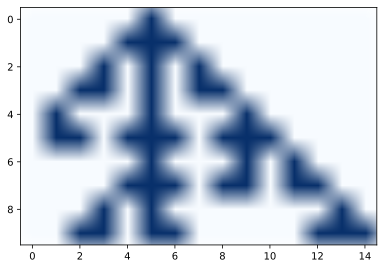

In [14]:
rows = 10
cols = 15
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 5] = 1

for i in range(1, rows):
    step(array, i)

plot_ca(array)

## Cross correlation

We can update the CA more quickly using "cross correlation".  The cross correlation of an array, `a`, with a window, `w`, is a new array, `c`, where element `k` is:

$ c_k = \sum_{n=0}^{N-1} a_{n+k} \cdot w_n $

In Python, we can compute element `k` like this:

In [15]:
def c_k(a, w, k):
    """Compute element k of the cross correlation of a and w.
    """
    N = len(w)
    return sum(a[k:k+N] * w)

To see how this works, I'll create an array:

In [16]:
N = 10
row = np.arange(N, dtype=np.uint8)
print(row)

[0 1 2 3 4 5 6 7 8 9]


And a window:

In [17]:
window = [1, 1, 1]

print(window)

[1, 1, 1]


With this window, each element of `c` is the sum of three neighbors in the array:

In [18]:
c_k(row, window, 0)

3

In [19]:
c_k(row, window, 1)

6

The following function computes the elements of `c` for all values of `k` where the window can overlap with the array:

In [20]:
def correlate(row, window):
    """Compute the cross correlation of a and w.
    """
    cols = len(row)
    N = len(window)
    c = [c_k(row, window, k) for k in range(cols-N+1)]
    return np.array(c)

In [21]:
c = correlate(row, window)
print(c)

[ 3  6  9 12 15 18 21 24]


This operation is useful in many domains, so libraries like NumPy usually provide an implementation.  Here's the version from NumPy.

In [23]:
c = np.correlate(row, window, mode='valid')
print(c)

[ 3  6  9 12 15 18 21 24]


With `mode='valid'`, the NumPy version does the same thing as mine: it only computes the elements of `c` where the window overlaps with the array.  A drawback of this mode is that the result is smaller than `array`.

And alternative is `mode='same'`, which makes the result the same size as `array` by extending array with zeros on both sides.  Here's the result:

In [24]:
c = np.correlate(row, window, mode='same')
print(c)

[ 1  3  6  9 12 15 18 21 24 17]


**Exercise:** Write a version of `correlate` that returns the same result as `np.correlate` with `mode='same'.`

In [25]:
# Hint: use np.pad to add zeros at the beginning and end of `row`

np.pad(row, 1, 'constant')

array([0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0], dtype=uint8)

In [29]:
def new_correlate(row, window):
    cols = len(row)
    N = len(window)
    pad = np.pad(row, 1, 'constant')
    c = [c_k(pad, window, k) for k in range(cols)]
    return np.array(c)

c = new_correlate(row, window)
print(c)

[ 1  3  6  9 12 15 18 21 24 17]


## Update with correlate

Now we can use `np.correlate` to update the array.  I'll start again with an array that contains one column for each cell and one row for each time step, and I'll initialize the first row with a single "on" cell in the middle:

In [30]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


Now here's a version of `step` that uses `np.correlate`

In [31]:
def step2(array, i, window=[1,1,1]):
    """Compute row i of a CA.
    """
    row = array[i-1]
    c = np.correlate(row, window, mode='same')
    array[i] = c % 2

And the result is the same.

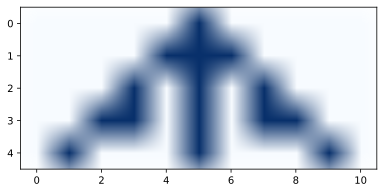

In [32]:
for i in range(1, rows):
    step2(array, i)

plot_ca(array)

## CA Tables

What we have so far is good enough for a CA that only depends on the total number of "on" cells, but for more general CAs, we need a table that maps from the configuration of the neighborhood to the future state of the center cell.

The following function makes the table by interpreting the Rule number in binary.

In [33]:
def make_table(rule):
    """Make the table for a given CA rule.
    
    rule: int 0-255
    
    returns: array of 8 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]
    return table

Here's what it looks like as an array:

In [34]:
table = make_table(150)
print(table)

[0 1 1 0 1 0 0 1]


If we correlate the row with the window `[4, 2, 1]`, it treats each neighborhood as a binary number between 000 and 111.

In [35]:
window = [4, 2, 1]
c = np.correlate(array[0], window, mode='same')
print(array[0])
print(c)

[0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 2 4 0 0 0 0]


Now we can use the result from `np.correlate` as an index into the table; the result is the next row of the array.

In [36]:
array[1] = table[c]
print(array[1])

[0 0 0 0 1 1 1 0 0 0 0]


We can wrap up that code in a function:

In [37]:
def step3(array, i, window=[4,2,1]):
    """Compute row i of a CA.
    """
    row = array[i-1]
    c = np.correlate(row, window, mode='same')
    array[i] = table[c]

And test it again.

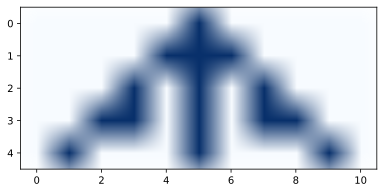

In [38]:
for i in range(1, rows):
    step3(array, i)

plot_ca(array)

How did I know that Rule 150 is the same as the previous CA?  I wrote out the table and converted it to binary.

## The Cell1D object

`Cell1D` encapsulates the code from the previous section.

In [39]:
class Cell1D:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, rule, n, m=None):
        """Initializes the CA.

        rule: integer
        n: number of rows
        m: number of columns

        Attributes:
        table:  rule dictionary that maps from triple to next state.
        array:  the numpy array that contains the data.
        next:   the index of the next empty row.
        """
        self.table = make_table(rule)
        self.n = n
        self.m = 2*n + 1 if m is None else m

        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[0, self.m//2] = 1
        self.next += 1

    def start_random(self):
        """Start with random values in the top row."""
        self.array[0] = np.random.random(self.m).round()
        self.next += 1

    def start_string(self, s):
        """Start with values from a string of 1s and 0s."""
        # TODO: Check string length
        self.array[0] = np.array([int(x) for x in s])
        self.next += 1

    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [4, 2, 1]
        c = np.correlate(a[i-1], window, mode='same')
        a[i] = self.table[c]
        self.next += 1

    def draw(self, start=0, end=None):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = self.array[:, start:end]
        plt.imshow(a, cmap='Blues', alpha=0.7)
        
        # turn off axis tick marks
        plt.xticks([])
        plt.yticks([])

The following function makes and draws a CA.

In [40]:
def draw_ca(rule, n=32):
    """Makes and draw a 1D CA with a given rule.
    
    rule: int rule number
    n: number of rows
    """
    ca = Cell1D(rule, n)
    ca.start_single()
    ca.loop(n-1)
    ca.draw()

Here's an example that runs a Rule 50 CA for 10 steps.

Saving figure to file chap05-1.pdf


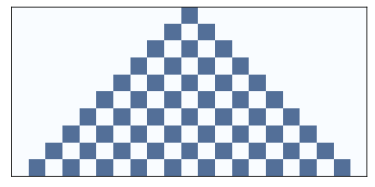

In [41]:
draw_ca(rule=50, n=10)
savefig('chap05-1.pdf')

Another example:

Saving figure to file chap05-2.pdf


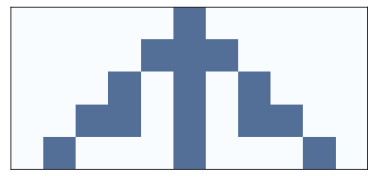

In [42]:
draw_ca(rule=150, n=5)

savefig('chap05-2.pdf')

And one more example showing recursive structure.

Saving figure to file chap05-3.pdf


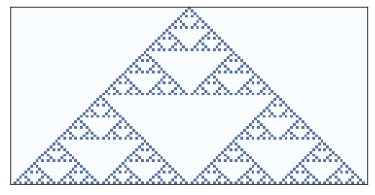

In [43]:
draw_ca(rule=18, n=64)

savefig('chap05-3.pdf')

Rule 30 generates a sequence of bits that is indistinguishable from random:

Saving figure to file chap05-4.pdf


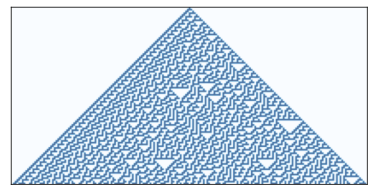

In [44]:
draw_ca(rule=30, n=100)

savefig('chap05-4.pdf')

And Rule 110 is Turing complete!

Saving figure to file chap05-5.pdf


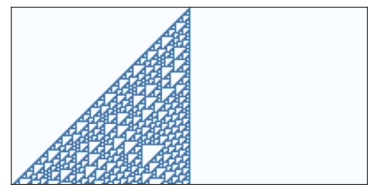

In [45]:
draw_ca(rule=110, n=100)

savefig('chap05-5.pdf')

Here's a longer run that has some spaceships.

Saving figure to file chap05-6.pdf


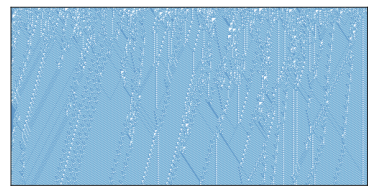

In [46]:
np.random.seed(21)

n = 600
ca = Cell1D(rule=110, n=n)
ca.start_random()
ca.loop(n-1)
ca.draw()

savefig('chap05-6.pdf')

## Exercises

**Exercise:** This exercise asks you to experiment with Rule 110 and see how
many spaceships you can find.

1. Read the [Wikipedia page about Rule 110](https://en.wikipedia.org/wiki/Rule_110), which describes its background pattern and spaceships.

2. Create a Rule 110 CA with an initial condition that yields the
  stable background pattern.  Note that the CA class provides
`start_string`, which allows you to initialize the state of
the array using a string of `1`s and `0`s.

3. Modify the initial condition by adding different patterns in the
  center of the row and see which ones yield spaceships.  You might
  want to enumerate all possible patterns of $n$ bits, for some
  reasonable value of $n$.  For each spaceship, can you find the
  period and rate of translation?  What is the biggest spaceship you
  can find?

4. What happens when spaceships collide?

In [65]:
def rule110CA(pattern):
    rule = 110
    m = len(pattern)
    n = None
    n = m if n is None else n
    
    CA = Cell1D(rule, n, m)
    CA.start_string(pattern)
    CA.loop(n-1) #loop for n 
    return CA

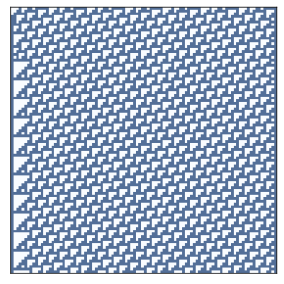

In [66]:
#the background pattern is fourteen cells wide and repeats itself exactly every seven iterations. The pattern is 00010011011111.
bck = '00010011011111'

caOne = rule110CA(bck * 7)
caOne.draw()

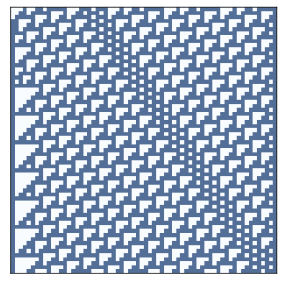

In [67]:
# structure shifts to the right two cells and repeats every three generations. It comprises the sequence 0001110111
shipOne = '0001110111'

caOne = rule110CA(bck + shipOne + bck * 3)
caOne.draw()

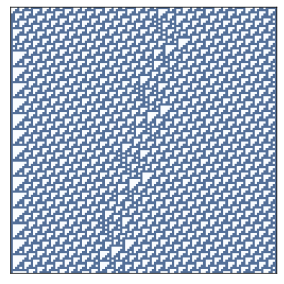

In [71]:
#The structure shifts left eight cells and repeats every thirty generations. It comprises the sequence 1001111 surrounded by the background pattern
shipTwo = '1001111'

caOne = rule110CA(bck * 5 + shipTwo + bck * 3)
caOne.draw()

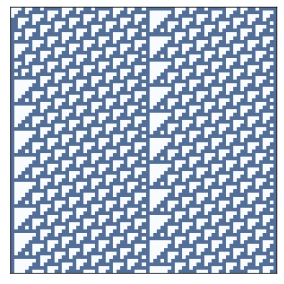

In [74]:
#The structure remains stationary and repeats every seven generations. It comprises the sequence 111 
# surrounded by the background pattern given above, as well as five different evolutions of this sequence.
shipThree = '111'

caOne = rule110CA(bck * 3 + shipThree + bck * 2)
caOne.draw()

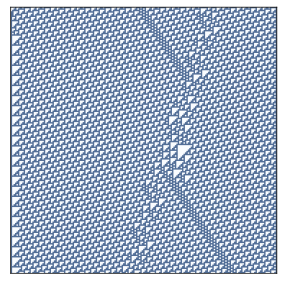

In [78]:
#ship 1 and 2 collision (no interaction)
strOne = bck + shipOne + bck * 3
strTwo = bck * 5 + shipTwo + bck * 3

caOne = rule110CA(bck * 6 + shipOne + bck * 3 + shipTwo + bck * 3)
caOne.draw()

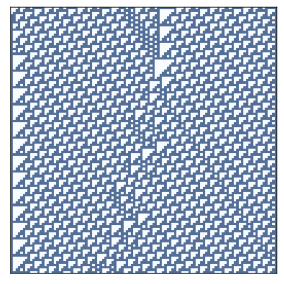

In [81]:
#ship 1 and 3 collision (interaction)
strOne = bck + shipOne + bck * 3
strThree = bck * 3 + shipThree + bck * 3

caOne = rule110CA(bck * 3 + shipOne + bck + shipThree + bck * 3)
caOne.draw()

### Note: for Lab 6, you are required to complete *one* of the following two exercises, not both

**Exercise:** The goal of this exercise is to implement a Turing machine.

1. Read about Turing machines at http://en.wikipedia.org/wiki/Turing_machine.

2. Write a class called `Turing` that implements a Turing machine.  For the action table, use the rules for a 3-state busy beaver.

3. Write a `draw` method that plots the state of the tape and the position and state of the head.  For one example of what that might look like, see http://mathworld.wolfram.com/TuringMachine.html.

In [120]:
# reference taken from Cell1D class
class Turing(Cell1D):
    
    def __init__(self, table, n, m=None):
        #from Wikipedia
        #A tape divided into cells, one next to the other. Each cell contains a symbol from some finite alphabet. 
        #A head that can read and write symbols on the tape and move the tape left and right one (and only one) cell at a time.
        #A state register that stores the state of the Turing machine, one of finitely many. Among these is the special start state with which the state register is initialized.
        #A finite table of instructions
        #States: A,B,C,HALT
        #initial state = A

        self.n = n
        self.m = n if m is None else m
        self.state = 'A'
        self.table = table

        self.tape = np.zeros((n, self.m), dtype=np.uint8)
        self.head = np.zeros(n, dtype=np.int64)
        self.head[0] = m//2
        self.next = 1
        
    def loop(self, steps=1):
        for i in range(steps):#have to use try except to break op
            try:
                self.step()
            except StopIteration:
                break
    
    def step(self):
        if self.state == 'HALT':
            raise StopIteration
            
        a = self.tape
        i = self.next
        a[i] = a[i-1]
        head = self.head[i-1]
        sym = a[i-1, head]
        #print(self.state, str='-> ')
        prev = self.state
        #prev state (symbol) to next state (symbol)
        new_sym, move, self.state = self.table[sym, self.state]
        print(move, end=': ')
        print(prev, end='-> ')
        print(self.state)
        
        #head manipulation
        a[i, head] = new_sym
        if move == 'R':
            head += 1
        else:
            head -= 1
        #next
        self.head[i] = head
        self.next += 1

    def draw(self, start=0, end=None):

        a = self.tape[:, start:end]#instead of array in Cell1D
        plt.imshow(a, cmap='Blues', alpha=0.7)
        #dont know how to make the individual points different shapes like in wolfram
        plt.plot(self.head, np.arange(len(self.head)))

In [124]:
#table with R and L for all A,B,C, HALT from Wikipedia State table for 3-state, 2-symbol busy beaver table
#note write symbol is always 1 whereas tape symbol changes 0 -> 1
table = {}
table[0, 'A'] = 1, 'R', 'B' 
table[0, 'B'] = 1, 'L', 'A' 
table[0, 'C'] = 1, 'L', 'B'
table[1, 'A'] = 1, 'L', 'C' 
table[1, 'B'] = 1, 'R', 'B' 
table[1, 'C'] = 1, 'R', 'HALT'

In [125]:
n = 15
m = 15
testTur = Turing(table, n, m)

testTur.loop(n-1)

R: A-> B
L: B-> A
L: A-> C
L: C-> B
L: B-> A
R: A-> B
R: B-> B
R: B-> B
R: B-> B
R: B-> B
L: B-> A
L: A-> C
R: C-> HALT


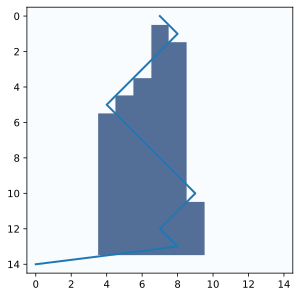

In [126]:
testTur.draw()

**Exercise:** This exercise asks you to implement and test several PRNGs.
For testing, you will need to install 
`DieHarder`, which you can download from 
https://www.phy.duke.edu/~rgb/General/dieharder.php, or it
might be available as a package for your operating system.

1. Write a program that implements one of the linear congruential
generators described at http://en.wikipedia.org/wiki/Linear_congruential_generator.
Test it using `DieHarder`.

2. Read the documentation of Python's `random` module.
What PRNG does it use?  Test it.

3. Implement a Rule 30 CA with a few hundred cells,
run it for as many time steps as you can in a reasonable amount
of time, and output the center column as a sequence of bits.
Test it.


In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here